### Importing and getting rawdata

In [3]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import h5py
from sklearn.utils import shuffle
from sklearn import svm

#: get data from h5
f = h5py.File('163223_Trajectories.hdf5','r')

# to view the insides of the h5, use print f.keys()
# print f['data']['Dependent0']
rawdata = f['data']['Dependent0'][()] #this turns the h5data into a numpy file
print('Shape of raw data: ', rawdata.shape)
f.close()


Shape of raw data:  (2, 5000, 4, 5000)


# 1. Preparing the rawdata into a proper format (feature vectors) to train our classifier 

### Get traj_demod and traj_av_demod from rawdata; [traj_demod, traj_av_demod]

In [4]:
#: params for the rawdata 
numTrajs = 5000 #num trajectories per label
duration = 5000 #time duration of entire track, in nanoseconds

#: params for demod
demod_freq =   0.047000000 #47 MHz = 0.047GHz
clock_freq = 1.000000000 # 1000MHz =1 GHz
rotation = 0
# demod_decay = None  #obsolete
start_window = 0 #units of time
end_window = duration #is this the correct end_window?



#: demod code
times = np.arange( int(start_window*clock_freq), int(end_window*clock_freq) ) * float(demod_freq/(clock_freq)) #unitless
demod_exp = np.exp(1j*(2*np.pi*times-rotation))
# if demod_decay is not None:   #obsolete
#     demod_exp *= np.exp(-1*times/(demod_decay*demod_freq))
demod_exp_I = np.array(np.real(demod_exp), dtype='float32')
demod_exp_Q = np.array(np.imag(demod_exp), dtype='float32')


#: traj_demod and traj_av_demod
traj_demod=np.zeros((2, 4, numTrajs, duration)) # indices are: iqIndex, labelIndex, trajIndex, timeIndex  ;  value is the i or q quadrature value
traj_av_demod=np.zeros((2, 4, duration)) # averages over the trajs; indices: iqIndex, labelIndex, timeIndex


for labelIndex in np.arange(4):
    for trajIndex in np.arange(numTrajs):
        traj_demod[0,labelIndex,trajIndex]=( (rawdata[0, trajIndex, labelIndex, :] - rawdata[0, trajIndex, labelIndex, :].mean())*demod_exp_I    -    (rawdata[1, trajIndex, labelIndex, :] - rawdata[1, trajIndex, labelIndex, :].mean())*demod_exp_Q)
        traj_demod[1,labelIndex,trajIndex]=( (rawdata[0, trajIndex, labelIndex, :] - rawdata[0, trajIndex, labelIndex, :].mean())*demod_exp_Q    +    (rawdata[1, trajIndex, labelIndex, :] - rawdata[1, trajIndex, labelIndex, :].mean())*demod_exp_I)
    traj_av_demod[0, labelIndex] = traj_demod[0, labelIndex,:,:].mean(0)
    traj_av_demod[1, labelIndex] = traj_demod[1, labelIndex,:,:].mean(0)
    

### Get feature vectors (slot-by-slot integrated form of I,Q quadratures) and labels; [inputData, labels01]; note: inputData only has gg and ee trajs

In [5]:
slotSize = 50 #please make duration divisible by slotSize
numSlots = duration/slotSize # num slots per traj
traj_demod_slotted = np.zeros((2, 4, numTrajs, numSlots)) # indices: iqIndex, labelIndex, trajIndex, slotIndex

for labelIndex in np.arange(4):
    for trajIndex in np.arange(numTrajs):
        for j in np.arange(numSlots): #j is slotIndex
            traj_demod_slotted[0,labelIndex, trajIndex, j] = traj_demod[0, labelIndex, trajIndex, j*slotSize:j*slotSize+slotSize].mean()
            traj_demod_slotted[1,labelIndex, trajIndex, j] = traj_demod[1, labelIndex, trajIndex, j*slotSize:j*slotSize+slotSize].mean()
            
#: data inputted into the SVM ; feature vectors are I traj concatted with Q traj
inputData = np.zeros([4*numTrajs, 2*numSlots]) # 4* numTrajs because 4 labels ; 2*numSlots because vector has both i and q trajs
inputData[0:numTrajs, :] = np.hstack([traj_demod_slotted[0, 0, :, :], traj_demod_slotted[1, 0, :, :]])
inputData[numTrajs:2*numTrajs, :] = np.hstack([traj_demod_slotted[0, 1, :, :], traj_demod_slotted[1, 1, :, :]])
inputData[2*numTrajs:3*numTrajs, :] = np.hstack([traj_demod_slotted[0, 2, :, :], traj_demod_slotted[1, 2, :, :]])
inputData[3*numTrajs:4*numTrajs, :] = np.hstack([traj_demod_slotted[0, 3, :, :], traj_demod_slotted[1, 3, :, :]])

#: labels to input into SVM; NOT all 4 labels; its 0 if gg, 1 if {ee,ge,eg}
labels01 = np.ones([4*numTrajs])
labels01[0:numTrajs] = np.zeros([numTrajs])

#: shuffle the data
inputData, labels01 = shuffle(inputData, labels01, random_state=0)



/home/qnl/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:3: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  app.launch_new_instance()
/home/qnl/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:8: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/qnl/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:9: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/qnl/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:12: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


# 2. Fit with SVM, only use training data

### Fit LinearSVM v1 (LinearSVC()). First try to plot fidelity vs C (for hyperparam tuning); find optimal C (manually)

For C= 1e-15 , fidelity:  0.5
For C= 1.4563484775e-15 , fidelity:  0.5
For C= 2.12095088792e-15 , fidelity:  0.5
For C= 3.08884359648e-15 , fidelity:  0.5
For C= 4.49843266897e-15 , fidelity:  0.5
For C= 6.5512855686e-15 , fidelity:  0.5
For C= 9.5409547635e-15 , fidelity:  0.5
For C= 1.38949549437e-14 , fidelity:  0.5
For C= 2.02358964773e-14 , fidelity:  0.5
For C= 2.94705170255e-14 , fidelity:  0.5
For C= 4.29193426013e-14 , fidelity:  0.5004901960784314
For C= 6.25055192527e-14 , fidelity:  0.5004901960784314
For C= 9.10298177992e-14 , fidelity:  0.5004901960784314
For C= 1.32571136559e-13 , fidelity:  0.5004901960784314
For C= 1.93069772888e-13 , fidelity:  0.5004901960784314
For C= 2.81176869797e-13 , fidelity:  0.5004901960784314
For C= 4.09491506238e-13 , fidelity:  0.5004901960784314
For C= 5.96362331659e-13 , fidelity:  0.5016252138439268
For C= 8.68511373751e-13 , fidelity:  0.5029280168443215
For C= 1.26485521686e-12 , fidelity:  0.5076621923937361
For C= 1.84206996933e-12 

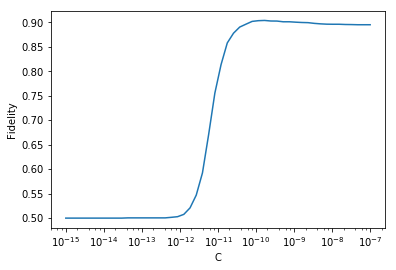

In [6]:
#: params
trainFraction = 4./5 #fraction of numTrajs to use as training set (validation set is part of the training set)
validationFraction = 1./4 # what fraction OF TRAINING SET to use for validation
lst_c = 10**np.linspace(-15, -7, 50) # list of C values (hyperparam for SVM) to train at


startIndex_testData = int(numTrajs*trainFraction) * 4 # start index for test data ; multipled by 4 because the data set is 4 * numTraj long
startIndex_validation = int(startIndex_testData * (1 - validationFraction))
lst_fid = []

for c in lst_c:
    clf_linearSVM_v1 = svm.LinearSVC(C=c)
    clf_linearSVM_v1.fit(inputData[0:startIndex_validation], labels01[0:startIndex_validation])
    
    #: find fidelity
    
    predicted_labels01 = clf_linearSVM_v1.predict(inputData[startIndex_validation:startIndex_testData])
    p_0_1 = 0 # Prob(0|excited)
    p_1_0 = 0 # Prob(1|gg)
    num_0 = 0 # number of gg's
    num_1 = 0 # number of excited states

    for i in np.arange(len(predicted_labels01)):
        if (labels01[startIndex_validation+i] == 1):
            num_1 = num_1 + 1
            if (predicted_labels01[i] == 0):
                p_0_1 = p_0_1 + 1
        elif (labels01[startIndex_validation+i] == 0):
            num_0 = num_0 + 1
            if (predicted_labels01[i] == 1):
                p_1_0 = p_1_0 + 1

    p_0_1 = 1.0 * p_0_1 / num_1
    p_1_0 = 1.0 * p_1_0 / num_0
    fid = 1 - (p_0_1 + p_1_0) / 2
    lst_fid = lst_fid + [fid]
    print('For C=', c, ', fidelity: ', fid)
    
plt.plot(lst_c, lst_fid)
plt.gca().set_xscale('log')
plt.xlabel('C')
plt.ylabel('Fidelity')

### Fit LinearSVM v2 (SVC(kernel='linear'))

In [8]:
# #: params
# trainFraction = 4./5 #fraction of numTrajs to use as training set (validation set is part of the training set)
# validationFraction = 1./4 # what fraction OF TRAINING SET to use for validation
# lst_c = 10**np.linspace(-13, -6, 20) # list of C values (hyperparam for SVM) to train at


# startIndex_testData = int(numTrajs*trainFraction) * 4 # start index for test data ; multipled by 4 because the data set is 4 * numTraj long
# startIndex_validation = int(startIndex_testData * (1 - validationFraction))
# lst_fid = []

# for c in lst_c:
#     clf_linearSVM_v2 = svm.SVC(kernel='linear', C=c)
#     clf_linearSVM_v2.fit(inputData[0:startIndex_validation], labels01[0:startIndex_validation])
    
#     #: find fidelity
    
#     predicted_labels01 = clf_linearSVM_v2.predict(inputData[startIndex_validation:startIndex_testData])
#     p_0_1 = 0 # Prob(0|excited)
#     p_1_0 = 0 # Prob(1|gg)
#     num_0 = 0 # number of gg's
#     num_1 = 0 # number of excited states

#     for i in np.arange(len(predicted_labels01)):
#         if (labels01[startIndex_validation+i] == 1):
#             num_1 = num_1 + 1
#             if (predicted_labels01[i] == 0):
#                 p_0_1 = p_0_1 + 1
#         elif (labels01[startIndex_validation+i] == 0):
#             num_0 = num_0 + 1
#             if (predicted_labels01[i] == 1):
#                 p_1_0 = p_1_0 + 1

#     p_0_1 = 1.0 * p_0_1 / num_1
#     p_1_0 = 1.0 * p_1_0 / num_0
#     fid = 1 - (p_0_1 + p_1_0) / 2
#     lst_fid = lst_fid + [fid]
#     print('For C=', c, ', fidelity: ', fid)
    
# plt.plot(lst_c, lst_fid)
# plt.gca().set_xscale('log')
# plt.xlabel('C')
# plt.ylabel('Fidelity')

### Fit RbfSVM (SVC(kernel='rbf'))

In [9]:
# #: params
# trainFraction = 4./5 #fraction of numTrajs to use as training set (validation set is part of the training set)
# validationFraction = 1./4 # what fraction OF TRAINING SET to use for validation
# lst_c = 10**np.linspace(-13, -6, 20) # list of C values (hyperparam for SVM) to train at


# startIndex_testData = int(numTrajs*trainFraction) * 4 # start index for test data ; multipled by 4 because the data set is 4 * numTraj long
# startIndex_validation = int(startIndex_testData * (1 - validationFraction))
# lst_fid = []

# for c in lst_c:
#     clf_rbfSVM = svm.SVC(kernel='rbf', C=c)
#     clf_rbfSVM.fit(inputData[0:startIndex_validation], labels01[0:startIndex_validation])
    
#     #: find fidelity
    
#     predicted_labels01 = clf_rbfSVM.predict(inputData[startIndex_validation:startIndex_testData])
#     p_0_1 = 0 # Prob(0|excited)
#     p_1_0 = 0 # Prob(1|gg)
#     num_0 = 0 # number of gg's
#     num_1 = 0 # number of excited states

#     for i in np.arange(len(predicted_labels01)):
#         if (labels01[startIndex_validation+i] == 1):
#             num_1 = num_1 + 1
#             if (predicted_labels01[i] == 0):
#                 p_0_1 = p_0_1 + 1
#         elif (labels01[startIndex_validation+i] == 0):
#             num_0 = num_0 + 1
#             if (predicted_labels01[i] == 1):
#                 p_1_0 = p_1_0 + 1

#     p_0_1 = 1.0 * p_0_1 / num_1
#     p_1_0 = 1.0 * p_1_0 / num_0
#     fid = 1 - (p_0_1 + p_1_0) / 2
#     lst_fid = lst_fid + [fid]
#     print('For C=', c, ', fidelity: ', fid)
    
# plt.plot(lst_c, lst_fid)
# plt.gca().set_xscale('log')
# plt.xlabel('C')
# plt.ylabel('Fidelity')

### Train the clf's with the optimal c

In [ ]:
clf_linearSVM_v1 = svm.LinearSVC(C=1.4e-10)
clf_linearSVM_v1.fit(inputData[0:startIndex_testData], labels01[0:startIndex_testData])

clf_linearSVM_v2 = svm.SVC(kernel='linear', C=1)
clf_linearSVM_v2.fit(inputData[0:startIndex_testData], labels01[0:startIndex_testData])

clf_rbfSVM = svm.SVC(kernel='rbf', C=1)
clf_rbfSVM.fit(inputData[0:startIndex_testData], labels01[0:startIndex_testData])

# 3. Calculate fidelity (on test set)

In [ ]:


predicted_labels01 = clf_linearSVM_v1.predict(inputData[startIndex_testData: ])
p_0_1 = 0 # Prob(0|excited)
p_1_0 = 0 # Prob(1|gg)
num_0 = 0 # number of gg's
num_1 = 0 # number of excited states


for i in np.arange(len(predicted_labels01)):
    if (labels01[startIndex_testData+i] == 1):
        num_1 = num_1 + 1
        if (predicted_labels01[i] == 0):
            p_0_1 = p_0_1 + 1
    elif (labels01[startIndex_testData+i] == 0):
        num_0 = num_0 + 1
        if (predicted_labels01[i] == 1):
            p_1_0 = p_1_0 + 1

p_0_1 = 1.0 * p_0_1 / num_1
p_1_0 = 1.0 * p_1_0 / num_0

fid = 1 - (p_0_1 + p_1_0) / 2
print('Fidelity: ', fid)
        
    

In [ ]:
clf_linearSVM.score(inputData[startIndex_testData: ], labels01[startIndex_testData:])

In [ ]:
lst_c.size
